# Notebook 03 — TF-IDF Baseline + Clustering

**Goal:** convert cleaned financial news headlines into numerical features and cluster them to identify recurring news themes.

**Why TF-IDF:** it is fast, interpretable, and provides a strong baseline. Any more complex embedding method should outperform this baseline to justify its use.

**Outputs:**
- cluster assignment for each headline
- top keywords per cluster (human-interpretable themes)
- saved artifacts for downstream notebooks

## Imports

We import libraries for:
- data manipulation
- TF-IDF feature extraction
- clustering (KMeans)
- clustering evaluation (silhouette score)
- basic visualization

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Load cleaned dataset

We load the processed dataset created in Notebook 02.
Using the cleaned dataset ensures all downstream analysis is based on
consistent, de-duplicated text.

In [2]:
df = pd.read_parquet("../data/processed/news_clean.parquet")
df.shape, df.columns.tolist()

((53155, 9),
 ['headlines',
  'time',
  'description',
  'source',
  'headline_raw',
  'headline_clean',
  'clean_len',
  'time_raw',
  'time_parsed'])

## Sanity checks

We inspect sample rows and source counts to confirm:
- the cleaned headline text looks reasonable
- source imbalance exists (e.g., Reuters dominates), which may affect clustering

In [3]:
df[["source", "headline_clean"]].head()

,source,headline_clean
0,CNBC,jim cramer: a better way to invest in the covi...
1,CNBC,cramer's lightning round: i would own teradyne
2,CNBC,"cramer's week ahead: big week for earnings, ev..."
3,CNBC,iq capital ceo keith bliss says tech and healt...
4,CNBC,wall street delivered the 'kind of pullback i'...


In [4]:
df["source"].value_counts()

source
Reuters     32572
Guardian    17795
CNBC         2788
Name: count, dtype: int64

## Handle Source Imbalance

Because news sources differ in size, clustering may overfit to the dominant
source’s language style.

To reduce this effect, we create a balanced subset with an equal number
of headlines per source and fit the clustering model on this subset.

In [5]:
min_n = df["source"].value_counts().min()
balanced = (
    df.groupby("source", group_keys=False)
      .apply(lambda x: x.sample(min_n, random_state=42))
      .reset_index(drop=True)
)

df.shape, balanced.shape, min_n

/tmp/ipykernel_2735/834473129.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_n, random_state=42))


((53155, 9), (8364, 9), np.int64(2788))

## Build TF-IDF features

TF-IDF converts headlines into a sparse numerical representation where:
- common words across headlines are downweighted
- rare, topic-revealing words are emphasized

We include unigrams and bigrams and limit vocabulary size
to reduce noise and improve clustering stability.

In [6]:
text = balanced["headline_clean"].astype(str).values

vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

X = vectorizer.fit_transform(text)
X.shape

(8364, 4331)

## Choose number of clusters (K)

We evaluate a range of cluster counts using silhouette score,
a heuristic that measures how well-separated clusters are.

This is not a perfect metric, but it provides a reasonable
starting point for selecting K.

In [7]:
ks = list(range(8, 21, 2))
scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

ks, scores

([8, 10, 12, 14, 16, 18, 20],
 [0.01290982986949124,
  0.014550273353716295,
  0.01643825423103957,
  0.01701786612634512,
  0.0174981830280843,
  0.019011442222387077,
  0.019702841965307694])

## Silhouette score visualization

We visualize silhouette score versus number of clusters
to identify diminishing returns as K increases.

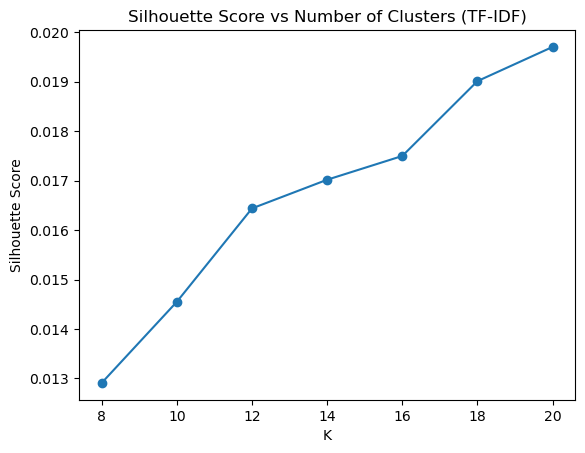

In [8]:
plt.figure()
plt.plot(ks, scores, marker="o")
plt.title("Silhouette Score vs Number of Clusters (TF-IDF)")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.show()

## Select final number of clusters

We select the K value with the highest silhouette score.
Manual overrides are acceptable if interpretability improves.

In [9]:
best_k = ks[int(np.argmax(scores))]
best_k

20

## Fit final clustering model

We fit KMeans using the selected number of clusters
and assign a cluster label to each headline
in the balanced dataset.

In [10]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
balanced["cluster"] = kmeans.fit_predict(X)

balanced[["source", "headline_clean", "cluster"]].head()

,source,headline_clean,cluster
0,CNBC,dow chemical ceo: 'i've never seen the industr...,9
1,CNBC,cramer dubs children's place a 'fabulous' buy ...,2
2,CNBC,the market's 'safe' stocks might not be so saf...,15
3,CNBC,cramer's lightning round: the case for buying ...,3
4,CNBC,cramer expects 'total revaluation' of comcast ...,5


## Interpret clusters using top keywords

To make clusters interpretable, we extract the highest-weight
TF-IDF terms from each cluster centroid.

These keywords serve as approximate “labels” describing
what each cluster is about.

In [11]:
terms = np.array(vectorizer.get_feature_names_out())
centroids = kmeans.cluster_centers_

def top_terms_for_cluster(cluster_id, top_n=12):
    idx = np.argsort(centroids[cluster_id])[::-1][:top_n]
    return terms[idx]

cluster_terms = {c: top_terms_for_cluster(c, top_n=12) for c in range(best_k)}
cluster_terms

{0: array(['business', 'to', 'small', 'business agenda', 'observer business',
        'observer', 'agenda', 'small business', 'in', 'business leader',
        'for', 'leader'], dtype=object),
 1: array(['everything jim', 'mad', 'mad money', 'everything',
        'money including', 'cramer said', 'on mad', 'said', 'said on',
        'including', 'money', 'jim cramer'], dtype=object),
 2: array(['for', 'on', 'of', 'says', 'and', 'over', 'ceo', 'cramer', 'at',
        'by', 'is', 'will'], dtype=object),
 3: array(['lightning', 'lightning round', 'cramer lightning', 'round',
        'cramer', 'is', 'stock', 'buy', 'the', 'this', 'of', 'round buy'],
       dtype=object),
 4: array(['remix', 'cramer remix', 'cramer', 'the', 'this', 'remix the',
        'is', 'stock', 'remix this', 'market', 'this stock', 'to'],
       dtype=object),
 5: array(['as', 'to', 'of', 'for', 'in', 'ceo', 'sales', 'china', 'on',
        'demand', 'new', 'high'], dtype=object),
 6: array(['in', 'to', 'ceo', 'for', 'o

In [12]:
for c in range(best_k):
    print(f"\nCluster {c}:")
    print(", ".join(cluster_terms[c]))


Cluster 0:
business, to, small, business agenda, observer business, observer, agenda, small business, in, business leader, for, leader

Cluster 1:
everything jim, mad, mad money, everything, money including, cramer said, on mad, said, said on, including, money, jim cramer

Cluster 2:
for, on, of, says, and, over, ceo, cramer, at, by, is, will

Cluster 3:
lightning, lightning round, cramer lightning, round, cramer, is, stock, buy, the, this, of, round buy

Cluster 4:
remix, cramer remix, cramer, the, this, remix the, is, stock, remix this, market, this stock, to

Cluster 5:
as, to, of, for, in, ceo, sales, china, on, demand, new, high

Cluster 6:
in, to, ceo, for, of, says, and, new, billion, china, on, deal

Cluster 7:
wall street, wall, street, cramer, jim, jim cramer, on, as, the, on wall, of wall, trade

Cluster 8:
with, to, in, on, the, talks with, ceo, up, talks, of, new, with the

Cluster 9:
the, of, cramer, is, and, to, in the, market, in, of the, on, for

Cluster 10:
after, to

## Inspect example headlines per cluster

We sample real headlines from each cluster to verify the cluster keywords match the actual content.
This prevents us from “believing the model” blindly.

In [13]:
for c in range(best_k):
    samp = balanced.loc[balanced["cluster"] == c, ["source", "headline_clean"]].sample(
        n=min(5, (balanced["cluster"] == c).sum()),
        random_state=42
    )
    print(f"\n=== Cluster {c} ===")
    for _, row in samp.iterrows():
        print(f"- [{row['source']}] {row['headline_clean']}")


=== Cluster 0 ===
- [Guardian] observer business agenda has royal mail got the answer to bt's pensions problem
- [CNBC] salesforce co-ceo keith block downplays profit forecastguidance cut: 'business looks strong'
- [Guardian] five reasons why trump's new tax cut plan would boost small business
- [Guardian] business made simple stuck in meetings all day salvation is at hand
- [Reuters] chinese government doesn't get involved in huawei's business: german boss

=== Cluster 1 ===
- [CNBC] everything jim cramer said on 'mad money,' including stock valuations, canopy growth vapes
- [CNBC] everything jim cramer said on 'mad money,' including protect gains, short-seller pain, chipotle cfo
- [CNBC] everything jim cramer said on 'mad money,' including understanding wall street jargon
- [CNBC] everything jim cramer said on 'mad money,' including bull stocks, fed cut mistake, chevron ceo
- [CNBC] everything jim cramer said on 'mad money,' including playing the rotation, gold and bond prices

=== 

## Compare clusters across news sources

We compute normalized cluster distributions per source
to identify whether certain themes are emphasized more
by one outlet than another.

This is where framing differences become measurable.

In [14]:
dist = pd.crosstab(balanced["source"], balanced["cluster"], normalize="index")
dist

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
source,,,,,,,,,,,,,,,,,,,,
CNBC,0.008250,0.039096,0.131994,0.170014,0.120158,0.017934,0.040531,0.019727,0.021879,0.167862,0.022238,0.025825,0.013630,0.000000,0.000000,0.123745,0.000000,0.011478,0.004304,0.061334
Guardian,0.027977,0.000000,0.227044,0.000000,0.000000,0.055595,0.079627,0.003587,0.033716,0.124821,0.037661,0.011119,0.026184,0.118723,0.034792,0.000000,0.032999,0.040172,0.021879,0.124103
Reuters,0.017934,0.000000,0.290531,0.000000,0.000000,0.076040,0.129842,0.016499,0.055237,0.022238,0.042324,0.058465,0.041966,0.016141,0.000000,0.000000,0.000000,0.031564,0.023314,0.177905


## Visualize cluster distribution by source

We visualize normalized cluster shares to highlight
differences in thematic focus across CNBC, Reuters,
and The Guardian.

<Figure size 640x480 with 0 Axes>

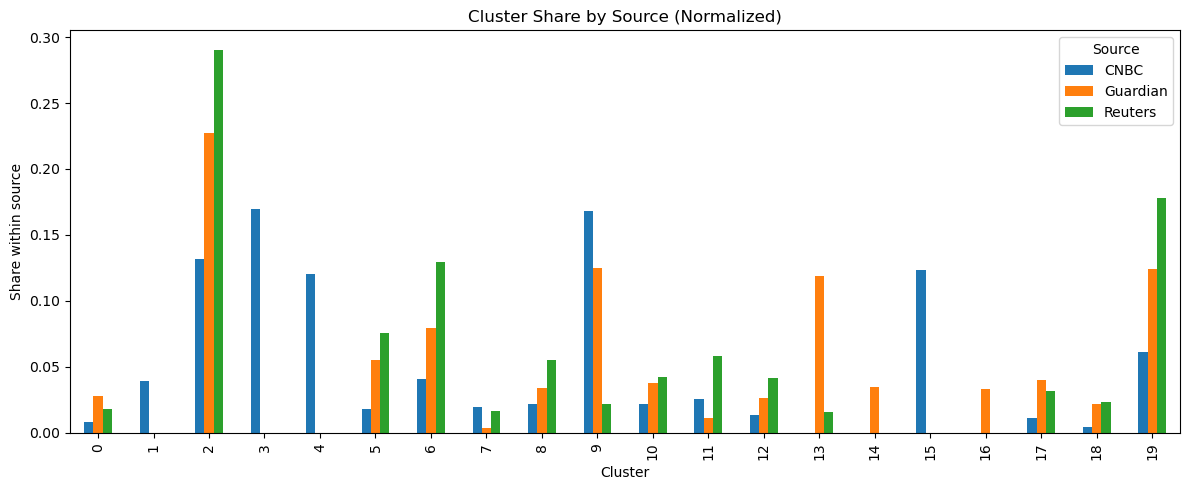

In [15]:
plt.figure()
dist.T.plot(kind="bar", figsize=(12, 5))
plt.title("Cluster Share by Source (Normalized)")
plt.xlabel("Cluster")
plt.ylabel("Share within source")
plt.legend(title="Source")
plt.tight_layout()
plt.show()

## Save clustering artifacts

We persist:
- the balanced dataset with cluster labels
- a table of top keywords per cluster

These artifacts allow reuse in later notebooks
without re-running clustering.

In [16]:
out_dir = Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

balanced.to_parquet(out_dir / "news_balanced_with_clusters.parquet", index=False)

# Save cluster keyword table
cluster_kw = pd.DataFrame({
    "cluster": list(cluster_terms.keys()),
    "top_terms": [", ".join(cluster_terms[c]) for c in cluster_terms]
})
cluster_kw.to_csv(out_dir / "cluster_top_terms.csv", index=False)

(out_dir / "news_balanced_with_clusters.parquet").as_posix(), (out_dir / "cluster_top_terms.csv").as_posix()

('../data/processed/news_balanced_with_clusters.parquet',
 '../data/processed/cluster_top_terms.csv')

## Summary

In this notebook we:
- loaded the cleaned headline dataset
- built TF-IDF representations (including bigrams)
- clustered headlines into thematic groups using KMeans
- interpreted clusters using top keywords and example headlines
- compared thematic emphasis across news sources
- saved clustering outputs for downstream analysis

Next, we will explore stronger representations
(embeddings and/or topic modeling) to improve
semantic coherence and interpretability.